In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load data in ##

In [191]:
df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190629.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190622.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190615.txt')
df4 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190608.txt')
june_data_raw = pd.concat([df1,df2,df3,df4], ignore_index = True)

In [192]:
zip_codes = pd.read_csv('https://raw.githubusercontent.com/galenballew/Metis-Submissions/master/projects/01%20Benson/data/processed/zips.csv')


In [193]:
zip_codes['zip_code']=zip_codes['zip_code'].astype('str')
zip_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   station   370 non-null    object
 1   zip_code  370 non-null    object
dtypes: object(2)
memory usage: 5.9+ KB


In [194]:
income_data = pd.read_csv('NY_Income_by_Zipcode.csv')
income_data = income_data.filter(['Geographic Area Name', 'Estimate!!Households!!Median income (dollars)'])
income_data.rename(columns={'Geographic Area Name' : 'zipcode','Estimate!!Households!!Median income (dollars)': 'Median income'}, inplace = True)
income_data['zipcode']=income_data['zipcode'].str.replace(r'ZCTA5 ', '')
income_data[income_data['zipcode']=='10020'] = '57782'
income_data[income_data['zipcode']=='10119'] = '57782'
income_data

,zipcode,Median income
0,06390,61125
1,10001,92840
2,10002,36982
3,10003,118161
4,10004,190223
...,...,...
34963,00983,25750
34964,00985,26156
34965,00987,32555
34966,New York,68486


In [195]:
zip_codes=zip_codes.set_index('zip_code').join(income_data.set_index('zipcode')).reset_index().drop_duplicates(subset=['station'])

In [196]:
zip_codes.rename(columns = {'index': 'zipcode', 'Median income': 'zip income'},inplace=True)


In [197]:
zip_codes['zip income']=zip_codes['zip income'].astype('float')
zip_codes.fillna(57782, inplace=True)
zip_codes

,zipcode,station,zip income
0,10001,28 ST,92840.0
2,10001,THIRTY ST,92840.0
4,10001,THIRTY THIRD ST,92840.0
6,10001,33 ST,92840.0
8,10001,34 ST-HUDSON YD,92840.0
...,...,...,...
722,7114,NEWARK C,57782.0
723,7302,GROVE STREET,57782.0
724,7302,EXCHANGE PLACE,57782.0
725,7306,JOURNAL SQUARE,57782.0


## Cleaning: ##

Fix column names by clarifying entries and exits are cumulative, add a combined datetime column, get rid of times that aren't on the hour (these seem to have weird results that throw the others off)

In [226]:
june_data_raw.rename(columns={'EXITS                                                               ':"CU_EXITS", \
                          'ENTRIES': 'CU_ENTRIES'}, inplace=True)
june_data_raw['DATETIME'] = pd.to_datetime(june_data_raw['DATE'] + ' ' + june_data_raw['TIME'])
june_data_raw = june_data_raw[(june_data_raw['DATETIME'].dt.minute==0)&(june_data_raw['DATETIME'].dt.second==0)].copy()

## Processing ##

In [227]:
#Group the turnstile data together by datetime, not sure if this is necessary since each turnstile at each time 
#only appears once, may be able to get rid of this
june_data = (june_data_raw.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE", 'TIME'],as_index=False)
            [['CU_ENTRIES','CU_EXITS']].last())

In [228]:
#Add columns for entries since the last timestep for each turnstile
june_data[['ENTRIES','EXITS']] = (june_data
                                          .groupby(["C/A", "UNIT", "SCP", "STATION"])[[ "CU_ENTRIES", 'CU_EXITS']]
                                          .apply(lambda x: x.subtract(x.shift(1))))
june_data.dropna(inplace=True)

In [229]:
#Add up turnstiles to get entries and exits for station during the specified time interval (4 hours before timestamp)
june_data = june_data.groupby(['STATION', 'DATE', 'TIME'])[['ENTRIES', 'EXITS']].sum().reset_index()

In [230]:
#More cleaning, get rid of bad values: negative or too high, 1 million people shouldnt pass through station
#in 4 hours
mask = ((june_data['ENTRIES'] >= 0) & \
        (june_data['EXITS'] >= 0) & \
        (june_data['ENTRIES'] < 1e6) & \
        (june_data['EXITS'] < 1e6))
june_data = june_data[mask].copy()

In [231]:
#Make total ridership column
june_data['TOTAL RIDERSHIP'] = june_data['ENTRIES']+june_data['EXITS']

In [232]:
june_data['DAYOFWEEK'] = pd.to_datetime(june_data['DATE']).dt.dayofweek

In [233]:
june_data = june_data.set_index('STATION').join(zip_codes.set_index('station')).reset_index()
june_data.rename(columns = {'index': 'STATION'},inplace=True)
june_data

,STATION,DATE,TIME,ENTRIES,EXITS,TOTAL RIDERSHIP,DAYOFWEEK,zipcode,zip income
0,1 AV,06/01/2019,04:00:00,643.0,627.0,1270.0,5,10009,63717.0
1,1 AV,06/01/2019,08:00:00,182.0,609.0,791.0,5,10009,63717.0
2,1 AV,06/01/2019,12:00:00,776.0,1697.0,2473.0,5,10009,63717.0
3,1 AV,06/01/2019,16:00:00,1933.0,2325.0,4258.0,5,10009,63717.0
4,1 AV,06/01/2019,20:00:00,1883.0,2443.0,4326.0,5,10009,63717.0
...,...,...,...,...,...,...,...,...,...
65693,ZEREGA AV,06/28/2019,05:00:00,66.0,103.0,169.0,4,10462,54278.0
65694,ZEREGA AV,06/28/2019,09:00:00,894.0,408.0,1302.0,4,10462,54278.0
65695,ZEREGA AV,06/28/2019,13:00:00,520.0,292.0,812.0,4,10462,54278.0
65696,ZEREGA AV,06/28/2019,17:00:00,611.0,543.0,1154.0,4,10462,54278.0


In [206]:
june_data.groupby(['STATION', 'DATE'])['TIME'].count().sort_values(ascending=False)

STATION          DATE      
FULTON ST        06/27/2019    18
                 06/14/2019    18
                 06/03/2019    18
                 06/04/2019    18
                 06/05/2019    18
                               ..
6 AV             06/05/2019     2
191 ST           06/13/2019     2
190 ST           06/09/2019     2
AVENUE I         06/09/2019     1
THIRTY THIRD ST  06/03/2019     1
Name: TIME, Length: 9960, dtype: int64

## From here we can split off the data into various forms that we want to look at ##

**Daily ridership data for each station**

In [234]:
june_data_daily = june_data.groupby(['STATION', 'DATE','DAYOFWEEK'])[['TOTAL RIDERSHIP']].sum().reset_index()

In [235]:
june_data_daily

,STATION,DATE,DAYOFWEEK,TOTAL RIDERSHIP
0,1 AV,06/01/2019,5,13118.0
1,1 AV,06/02/2019,6,13207.0
2,1 AV,06/03/2019,0,35980.0
3,1 AV,06/04/2019,1,36109.0
4,1 AV,06/05/2019,2,40614.0
...,...,...,...,...
9955,ZEREGA AV,06/24/2019,0,5236.0
9956,ZEREGA AV,06/25/2019,1,5128.0
9957,ZEREGA AV,06/26/2019,2,5590.0
9958,ZEREGA AV,06/27/2019,3,5203.0


In [ ]:
june_data_daily =

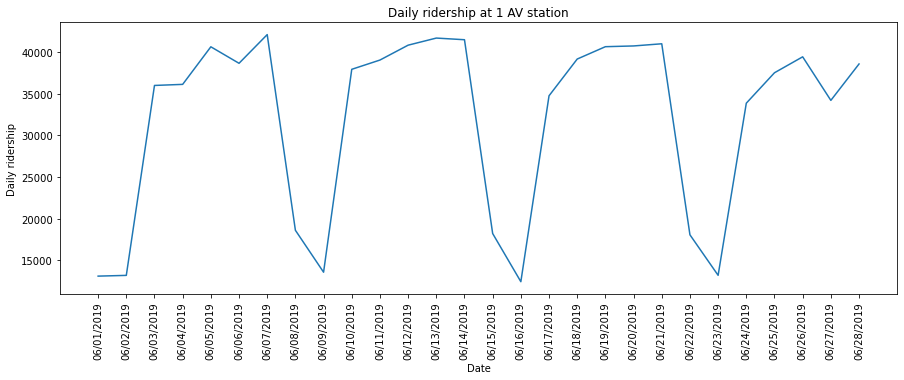

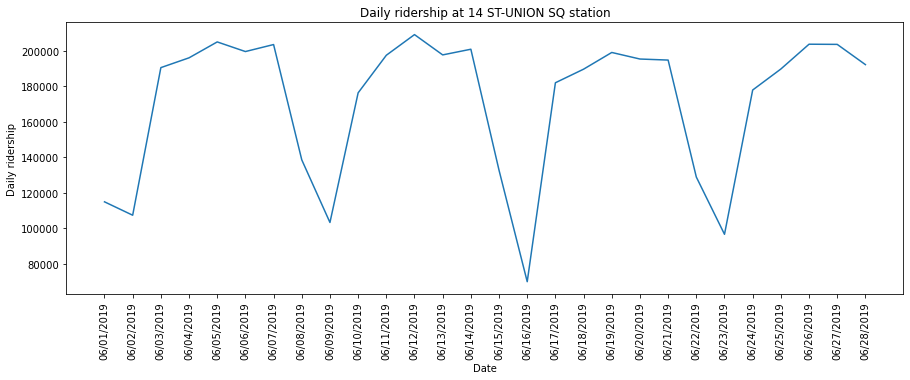

In [59]:
#Function for plotting monthly time series of stop
def plot_monthly_series(df, station):
    station_df = df.loc[df['STATION'] == station].copy()
    plt.figure(figsize = (15,5))
    plt.plot(station_df['DATE'], station_df['TOTAL RIDERSHIP'])
    plt.xticks(rotation = 'vertical')
    plt.xlabel('Date')
    plt.ylabel('Daily ridership')
    plt.title('Daily ridership at ' + station + ' station')
    plt.show()
plot_monthly_series(june_data_daily, '1 AV')
plot_monthly_series(june_data_daily, '14 ST-UNION SQ')

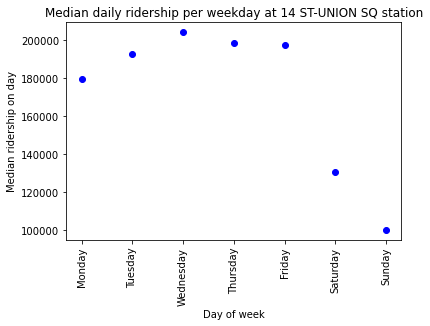

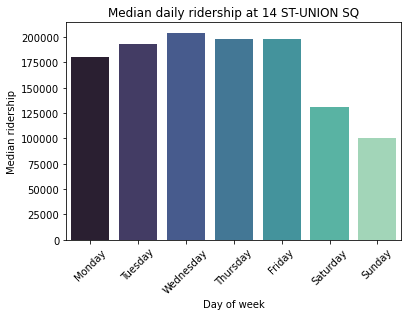

In [110]:
days = ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
#Function for plotting median ridership at a station 
def plot_weekly(df, station):
    station_df = df.loc[df['STATION'] == station].copy()
    median_ridership = station_df.groupby(['DAYOFWEEK'])['TOTAL RIDERSHIP'].median()
    plt.plot(days, median_ridership, 'bo')
    plt.xticks(rotation = 'vertical')
    plt.xlabel('Day of week')
    plt.ylabel('Median ridership on day')
    plt.title('Median daily ridership per weekday at ' + station + ' station')
    plt.show()
    ax=sns.barplot(x = days, y = median_ridership, palette = 'mako')
    ax.set(xlabel = 'Day of week', ylabel = 'Median ridership', title = 'Median daily ridership at '+ station)
    plt.xticks(rotation = 45)
plot_weekly(june_data_daily, '14 ST-UNION SQ')

In [61]:
june_data_hourly = june_data.groupby(['STATION', 'TIME','DAYOFWEEK'])[['TOTAL RIDERSHIP']].sum().reset_index()

In [62]:
june_data_hourly

,STATION,TIME,DAYOFWEEK,TOTAL RIDERSHIP
0,1 AV,00:00:00,0,8747.0
1,1 AV,00:00:00,1,15663.0
2,1 AV,00:00:00,2,19041.0
3,1 AV,00:00:00,3,19659.0
4,1 AV,00:00:00,4,20631.0
...,...,...,...,...
16587,ZEREGA AV,21:00:00,2,4764.0
16588,ZEREGA AV,21:00:00,3,4548.0
16589,ZEREGA AV,21:00:00,4,4345.0
16590,ZEREGA AV,21:00:00,5,2303.0


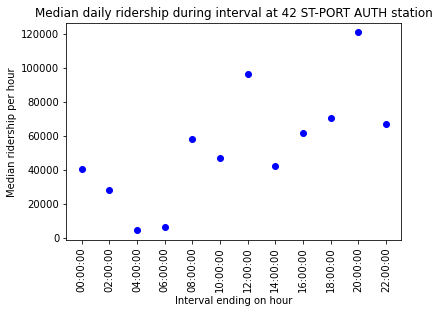

In [85]:
#Plot median 4-hourly traffic at station
def plot_hourly(df, station, weekday_only = True):
    station_df = df.loc[df['STATION'] == station].copy()
    if weekday_only:
        station_df = station_df[station_df['DAYOFWEEK']<=4] #0-4 = monday to friday
    median_ridership = station_df.groupby(['TIME'])['TOTAL RIDERSHIP'].median()
    plt.plot(median_ridership.index, median_ridership, 'bo')
    plt.xticks(rotation='vertical')
    plt.xlabel('Interval ending on hour')
    plt.ylabel('Median ridership per hour')
    plt.title('Median daily ridership during interval at ' + station + ' station')
    plt.show()

plot_hourly(june_data_hourly, '42 ST-PORT AUTH')

**Summary statistics for ridership across the whole month, indexed by station**

In [236]:
june_data_station_stats = june_data.groupby(['STATION','zip income'])['TOTAL RIDERSHIP']\
                            .agg([('MEAN', 'mean'),('MEDIAN', 'median'),('SUM', 'sum')])\
                            .reset_index().sort_values('MEDIAN', ascending = False).set_index('STATION')


In [237]:
june_data_station_stats

,zip income,MEAN,MEDIAN,SUM
STATION,,,,
14 ST-UNION SQ,118161.0,28884.969880,28541.0,4794905.0
TIMES SQ-42 ST,122484.0,29366.463855,28500.0,4874833.0
34 ST-HERALD SQ,104349.0,33574.556886,26438.0,5606951.0
34 ST-PENN STA,57782.0,23433.621622,18321.0,7803396.0
59 ST COLUMBUS,132605.0,19370.502994,16538.0,3234874.0
...,...,...,...,...
BEACH 98 ST,84485.0,190.467066,153.0,31808.0
TOMPKINSVILLE,54199.0,107.502994,106.0,17953.0
BEACH 105 ST,84485.0,108.844311,77.0,18177.0


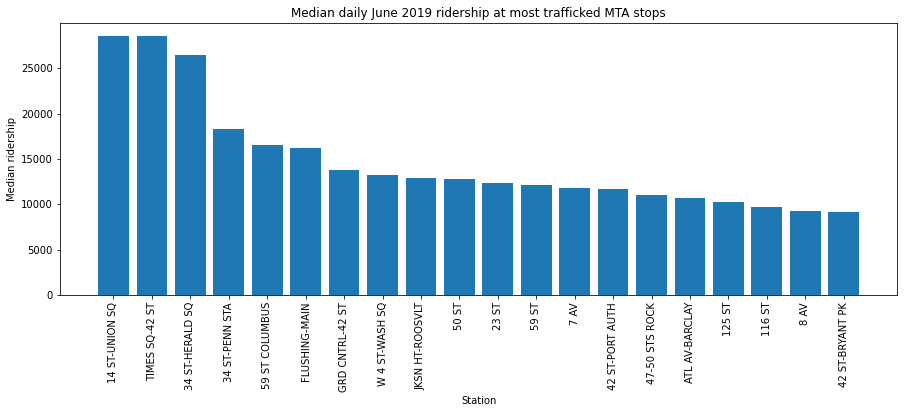

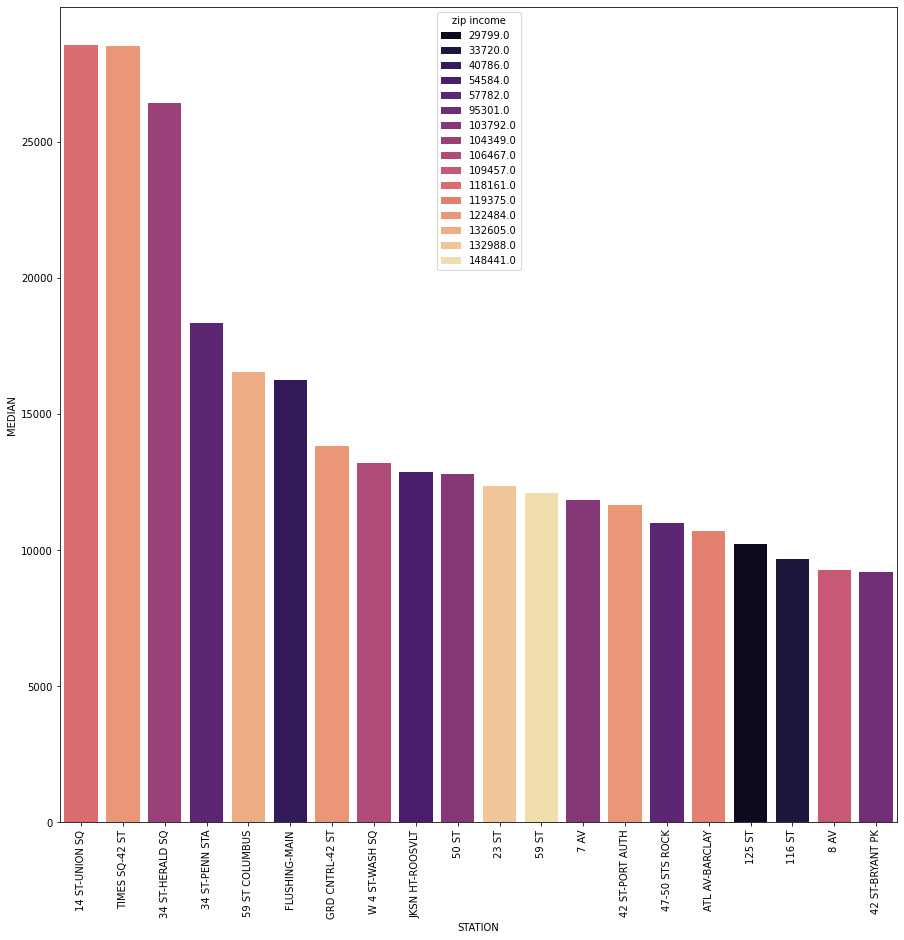

In [249]:
june_data_station_stats.sort_values('MEDIAN', ascending = False, inplace=True)
stations1 = june_data_station_stats.index
med_ridership = june_data_station_stats['MEDIAN']
plt.figure(figsize = (15,5))
plt.bar(stations1[:20], med_ridership[:20])
plt.xticks(rotation='vertical')
plt.xlabel('Station')
plt.ylabel('Median ridership')
plt.title('Median daily June 2019 ridership at most trafficked MTA stops')
plt.show()

plt.figure(figsize = (15,15))
sns.barplot(data = june_data_station_stats.reset_index()[:20], x = 'STATION', y = 'MEDIAN', palette= 'magma', hue = 'zip income',dodge=False)
plt.xticks(rotation='vertical')

plt.show()

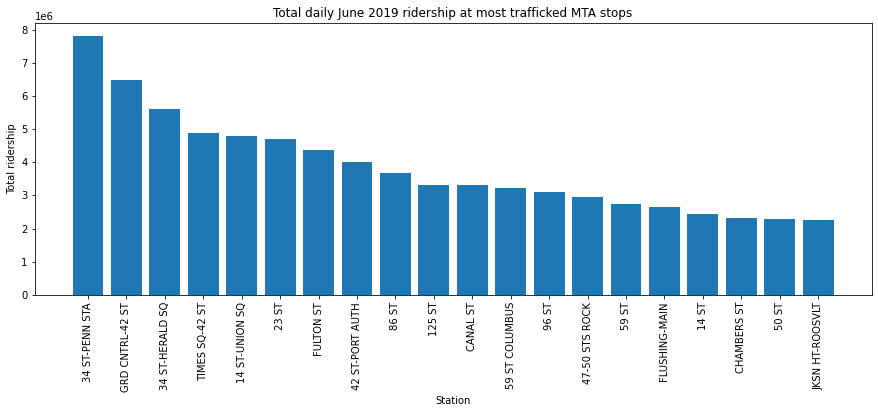

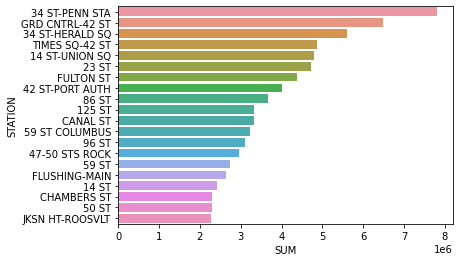

In [113]:
june_data_station_stats.sort_values('SUM', ascending = False, inplace=True)
stations2 = june_data_station_stats.index
total_ridership = june_data_station_stats['SUM']
plt.figure(figsize = (15,5))
plt.bar(stations2[:20], total_ridership[:20])
plt.xticks(rotation='vertical')
plt.xlabel('Station')
plt.ylabel('Total ridership')
plt.title('Total daily June 2019 ridership at most trafficked MTA stops')
plt.show()


sns.barplot(x=total_ridership[:20], y =stations2[:20])
plt.show()

In [84]:
#Print number of timestamps for top stations
for station in stations:
    print(station)
    print(june_data[june_data['STATION']==station].groupby(['STATION','DATE'])['TIME'].count().value_counts())

14 ST-UNION SQ
6    26
5     2
Name: TIME, dtype: int64
TIMES SQ-42 ST
6    26
5     2
Name: TIME, dtype: int64
34 ST-HERALD SQ
6    27
5     1
Name: TIME, dtype: int64
34 ST-PENN STA
12    26
10     1
11     1
Name: TIME, dtype: int64
59 ST COLUMBUS
6    27
5     1
Name: TIME, dtype: int64
FLUSHING-MAIN
6    27
5     1
Name: TIME, dtype: int64
GRD CNTRL-42 ST
12    26
10     1
11     1
Name: TIME, dtype: int64
W 4 ST-WASH SQ
6    27
5     1
Name: TIME, dtype: int64
JKSN HT-ROOSVLT
6    27
5     1
Name: TIME, dtype: int64
50 ST
6    26
5     2
Name: TIME, dtype: int64
23 ST
12    26
10     1
11     1
Name: TIME, dtype: int64
59 ST
6    26
5     2
Name: TIME, dtype: int64
7 AV
6    26
5     2
Name: TIME, dtype: int64
42 ST-PORT AUTH
12    26
10     1
11     1
Name: TIME, dtype: int64
47-50 STS ROCK
6    27
5     1
Name: TIME, dtype: int64
ATL AV-BARCLAY
6    26
5     2
Name: TIME, dtype: int64
125 ST
12    27
10     1
Name: TIME, dtype: int64
116 ST
6    27
5     1
Name: TIME, dtype: in

6    25
2     1
5     1
Name: TIME, dtype: int64
WEST FARMS SQ
6    26
4     1
5     1
Name: TIME, dtype: int64
4AV-9 ST
6    27
5     1
Name: TIME, dtype: int64
PELHAM BAY PARK
6    27
5     1
Name: TIME, dtype: int64
BAY RIDGE AV
6    27
5     1
Name: TIME, dtype: int64
MORISN AV/SNDVW
6    27
5     1
Name: TIME, dtype: int64
BEDFORD-NOSTRAN
6    27
5     1
Name: TIME, dtype: int64
GATES AV
6    26
5     2
Name: TIME, dtype: int64
52 ST
6    25
5     3
Name: TIME, dtype: int64
9 AV
6    27
5     1
Name: TIME, dtype: int64
170 ST
12    27
10     1
Name: TIME, dtype: int64
OZONE PK LEFFRT
6    27
5     1
Name: TIME, dtype: int64
BROADWAY
12    27
10     1
Name: TIME, dtype: int64
MOSHOLU PKWY
6    26
5     2
Name: TIME, dtype: int64
77 ST
12    27
10     1
Name: TIME, dtype: int64
BROOK AV
6    27
5     1
Name: TIME, dtype: int64
NORTHERN BLVD
6    27
5     1
Name: TIME, dtype: int64
HALSEY ST
12    27
10     1
Name: TIME, dtype: int64
67 AV
6    27
5     1
Name: TIME, dtype: int64
UNI

6    27
5     1
Name: TIME, dtype: int64
215 ST
6    27
5     1
Name: TIME, dtype: int64
AVENUE I
6    24
5     2
1     1
3     1
Name: TIME, dtype: int64
BEACH 36 ST
6    27
5     1
Name: TIME, dtype: int64
ATLANTIC AV
6    27
5     1
Name: TIME, dtype: int64
CYPRESS HILLS
6    27
5     1
Name: TIME, dtype: int64
NEPTUNE AV
6    27
5     1
Name: TIME, dtype: int64
E 143/ST MARY'S
6    27
5     1
Name: TIME, dtype: int64
ROCKAWAY PARK B
6    27
5     1
Name: TIME, dtype: int64
BEACH 90 ST
6    26
5     2
Name: TIME, dtype: int64
6 AV
3    14
4    10
5     2
2     1
6     1
Name: TIME, dtype: int64
BEACH 44 ST
6    27
5     1
Name: TIME, dtype: int64
AQUEDUCT RACETR
6    27
5     1
Name: TIME, dtype: int64
BEACH 98 ST
6    27
5     1
Name: TIME, dtype: int64
TOMPKINSVILLE
6    27
5     1
Name: TIME, dtype: int64
BEACH 105 ST
6    27
5     1
Name: TIME, dtype: int64
BROAD CHANNEL
6    27
5     1
Name: TIME, dtype: int64
ORCHARD BEACH
6    27
5     1
Name: TIME, dtype: int64
190 ST
5    1

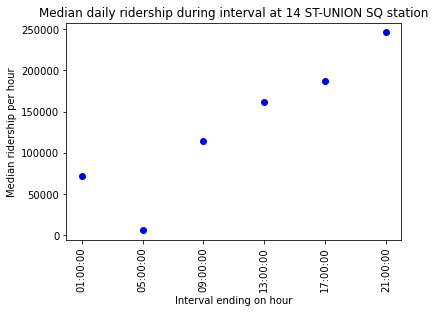

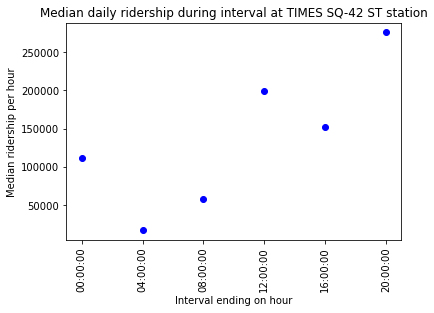

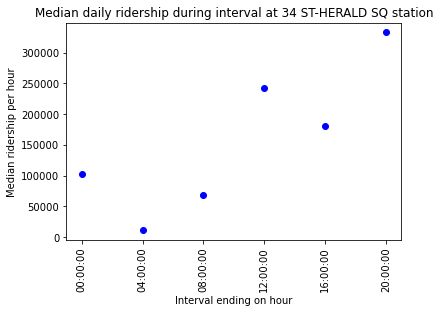

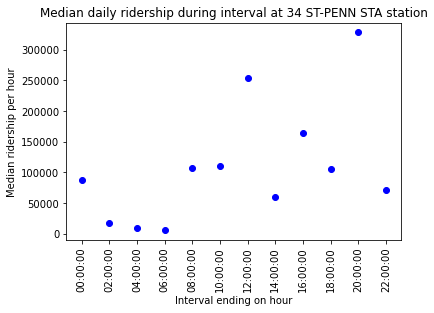

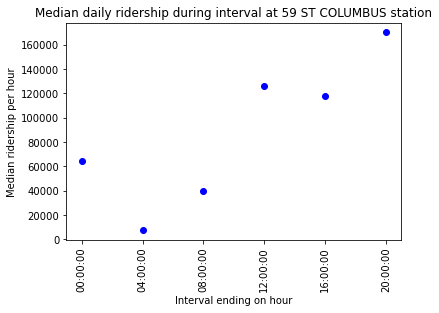

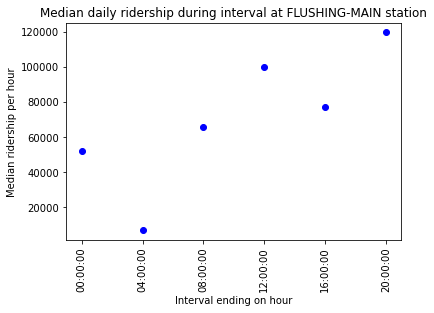

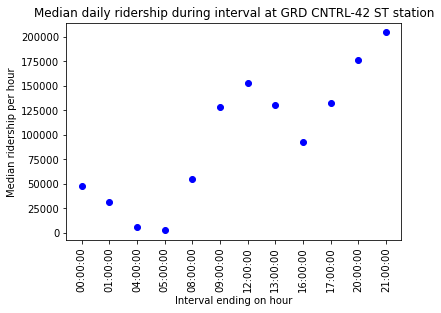

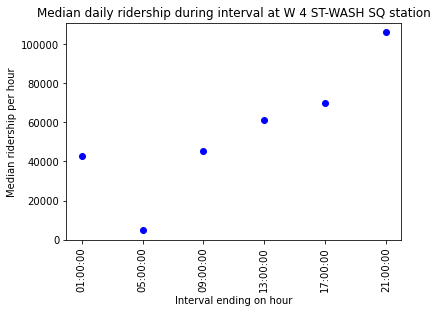

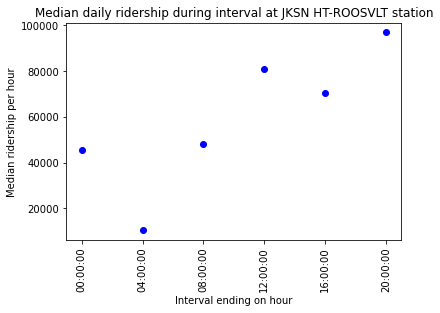

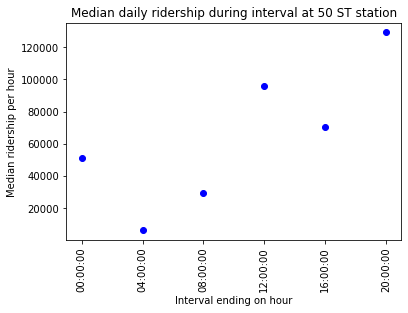

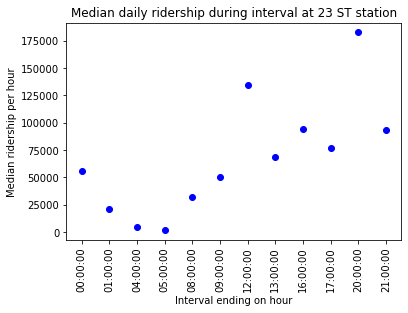

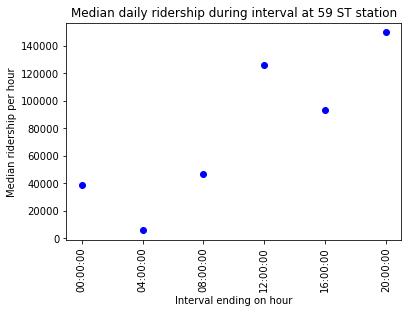

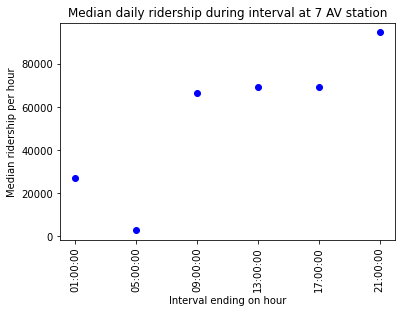

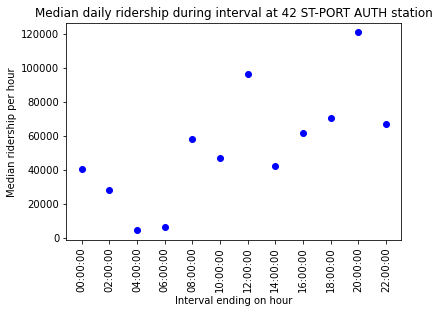

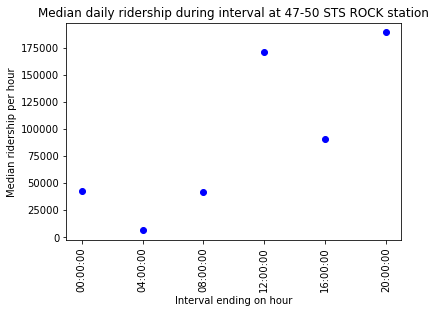

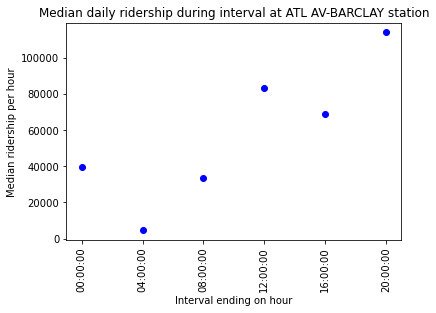

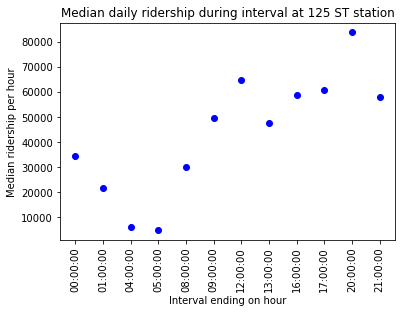

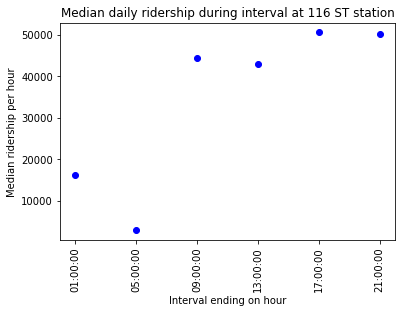

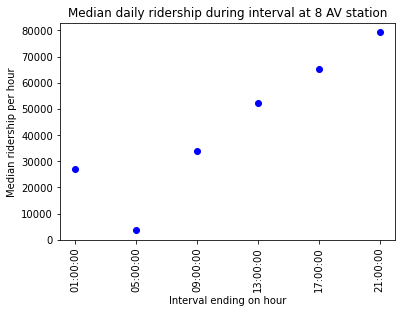

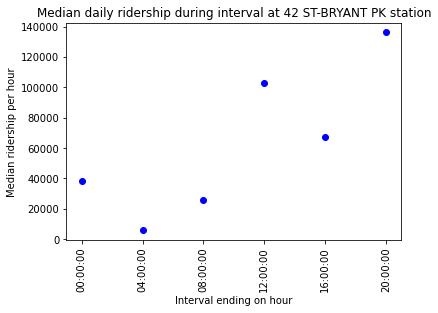

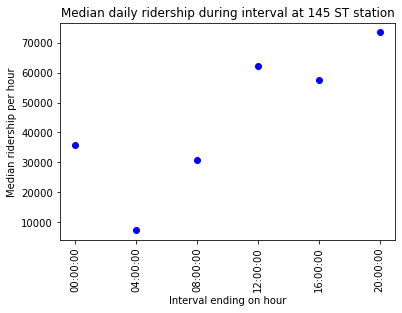

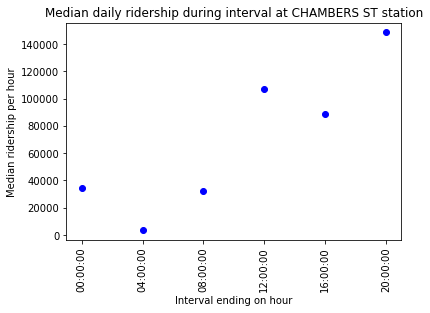

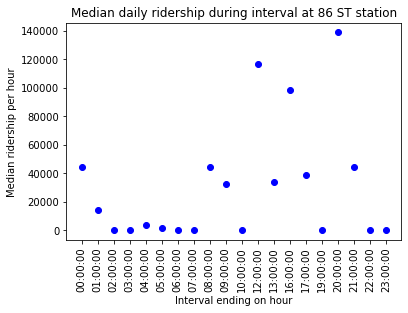

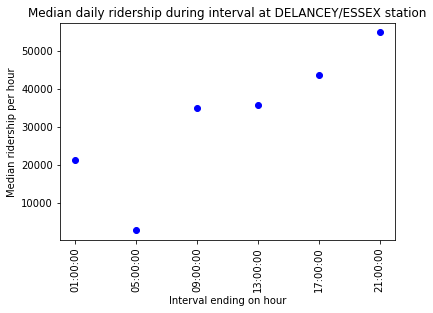

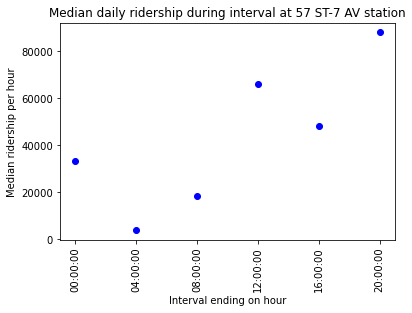

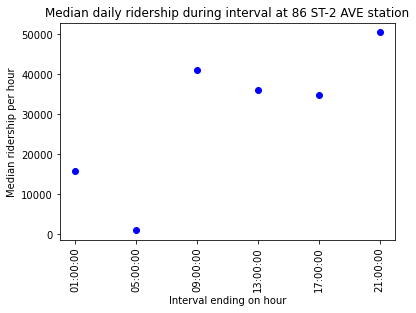

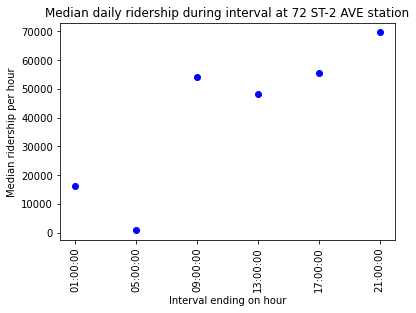

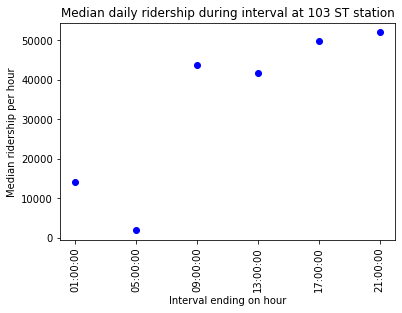

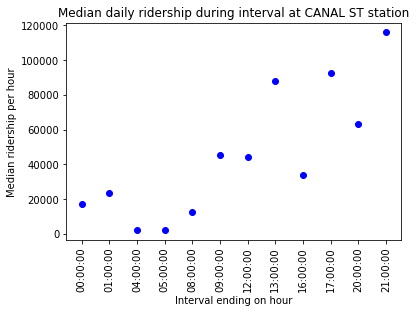

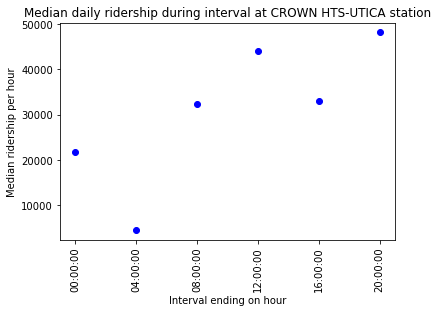

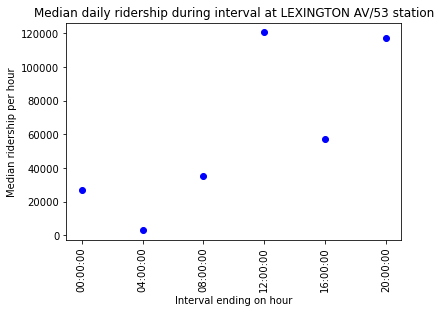

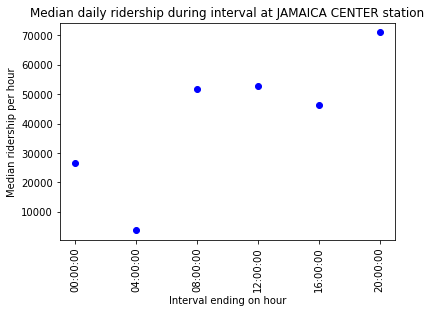

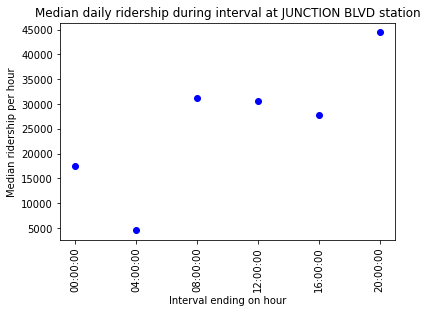

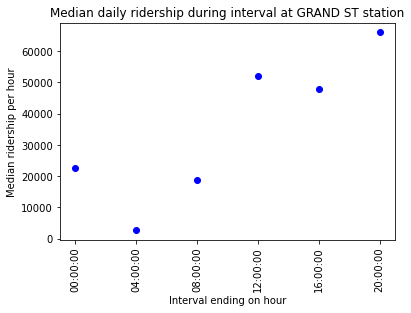

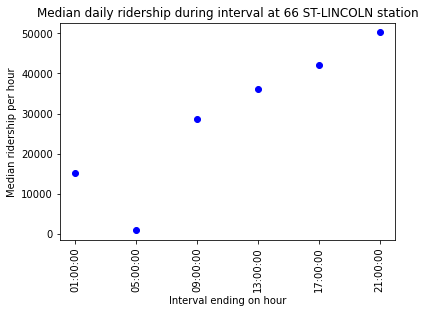

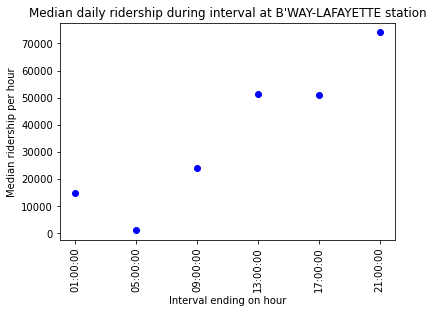

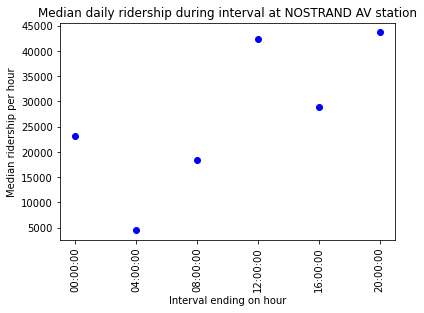

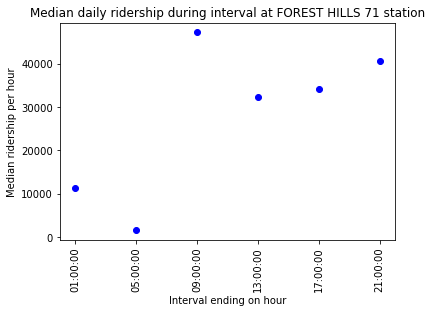

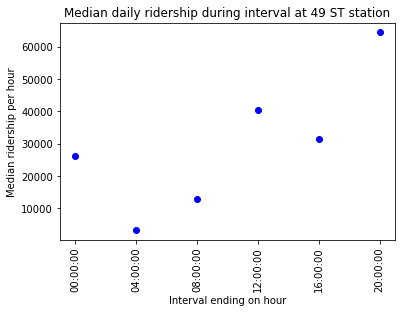

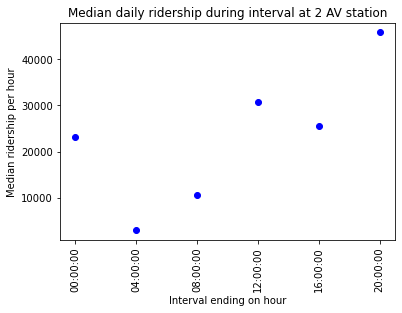

In [88]:
#plot hourly ridership for busiest stations
for station in stations[:40]:
    plot_hourly(june_data_hourly, station)

In [92]:
len(set(stations1[:20])&set(stations2[:20]))

14